# Datathon_2 - Atendimentos cirúrgicos
## Gustavo, Roberto, Letícia, Gabriela, Sidy, Luiz, Vítor

- Objetivo geral:
    - extrair informações analíticas dos atendimentos cirúrgicos para embasar tomada de decisões;
- Objetivo específico:
    - determinar o impacto que características do atendimento cirúrgico tem em sua duração

In [2]:
# importando bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
# importando bibliotecas - Clustering
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

##importing gower matrix
from gower import gower_matrix

#import KMedoids
from sklearn_extra.cluster import KMedoids

In [329]:
# importando biblitecas - regressão linear
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# configurando o ambiente

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib's runtime configuration (rc) to customize default settings
plt.rcParams["figure.figsize"] = [6, 3]

# %matplotlib inline

In [10]:
# importando o conjunto de dados
df_raw= pd.read_csv('datathon_CC.csv')

In [12]:
df_raw.head()

,Unnamed: 0,nascimento,sexo,data_entrada,data_saida,tipo_atendimento,tipo_passagem,procedimento_cirurgico,especialidade_procedimento,tecnica_cirurgica,potencial_contaminacao,porte,medico,especialidade_cirurgiao,asa,intercorrencia_intraop,tipo_intercorrencia_intraop
0,0,1997-08-19,Feminino,2019-01-23 13:49:31,2019-01-23 16:51:20,Clinica Cirurgica,INTERNADO,"Osteoplastia para prognatismo, micrognatismo o...",Cabeça e Pescoço,Convencional,CLASSE II - POTENCIALMENTE CONTAMINADA,P4,Lucas da Rosa,CIRURGIA BUCO-MAXILO-FACIAL,I,Não,Não Informado
1,1,1965-01-29,Feminino,2019-01-11 06:28:53,2019-01-11 14:59:42,Clinica Cirurgica,INTERNADO,Microcirurgia para tumores intracranianos,Neurocirurgia,Convencional,CLASSE I - LIMPA,P7,Gabrielly da Cunha,NEUROCIRURGIA,II,Não,Não Informado
2,2,1965-08-05,Masculino,2019-01-09 06:43:51,2019-01-09 10:50:57,Clinica Medica,INTERNADO,Cirurgia intracraniana por via endoscópica,Neurocirurgia,Vídeo,CLASSE I - LIMPA,P5,Caio Peixoto,NEUROCIRURGIA,II,Não,Não Informado
3,3,1988-04-18,Masculino,2019-01-10 06:02:59,2019-01-10 09:25:47,Clinica Cirurgica,INTERNADO,Gastroplastia para obesidade mórbida por video...,Cirurgia Geral,Vídeo,CLASSE II - POTENCIALMENTE CONTAMINADA,P5,Thiago da Mota,CIRURGIA DO APARELHO DIGESTIVO,II,Não,Não Informado
4,4,1965-06-21,Feminino,2019-01-10 05:51:42,2019-01-10 08:46:15,Clinica Cirurgica,INTERNADO,Artroplastia total de joelho com implantes - t...,Ortopedia,Convencional,CLASSE I - LIMPA,P4,Eduarda Mendes,ORTOPEDIA E TRAUMATOLOGIA,I,Não,Não Informado


In [14]:
df_raw.shape

(39468, 17)

In [16]:
# informações gerais e nulos
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39468 entries, 0 to 39467
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   39468 non-null  int64 
 1   nascimento                   39468 non-null  object
 2   sexo                         39468 non-null  object
 3   data_entrada                 39468 non-null  object
 4   data_saida                   39129 non-null  object
 5   tipo_atendimento             39468 non-null  object
 6   tipo_passagem                39468 non-null  object
 7   procedimento_cirurgico       39468 non-null  object
 8   especialidade_procedimento   39468 non-null  object
 9   tecnica_cirurgica            39468 non-null  object
 10  potencial_contaminacao       38115 non-null  object
 11  porte                        38886 non-null  object
 12  medico                       39468 non-null  object
 13  especialidade_cirurgiao      39

- Nulos em colunas potencialmente relevantes para a análise. Optou-se por removê-los pela volumetria relativamente baixa desses valores.

In [19]:
# remoção de nulos
df_01 = df_raw.copy()
df_01.dropna(how='any', inplace=True)
df_01.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37226 entries, 0 to 39467
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   37226 non-null  int64 
 1   nascimento                   37226 non-null  object
 2   sexo                         37226 non-null  object
 3   data_entrada                 37226 non-null  object
 4   data_saida                   37226 non-null  object
 5   tipo_atendimento             37226 non-null  object
 6   tipo_passagem                37226 non-null  object
 7   procedimento_cirurgico       37226 non-null  object
 8   especialidade_procedimento   37226 non-null  object
 9   tecnica_cirurgica            37226 non-null  object
 10  potencial_contaminacao       37226 non-null  object
 11  porte                        37226 non-null  object
 12  medico                       37226 non-null  object
 13  especialidade_cirurgiao      37226 n

In [21]:
df_01.shape

(37226, 17)

In [23]:
# identificação de linhas duplicadas
print('Atendimentos duplicados:', df_raw.duplicated().sum())

Atendimentos duplicados: 3974


In [25]:
# remoção de linhas duplicadas
df_01 = df_01.drop_duplicates()
df_01.shape

(33467, 17)

- Ajuste do dtype das datas e criação da variável "idade"

In [28]:
# Convertendo as colunas "nascimento", "data_entrada" e "data_saída" para o formato de data
df_01['nascimento'] = pd.to_datetime(df_01['nascimento'])
df_01['data_entrada'] = pd.to_datetime(df_01['data_entrada'])
df_01['data_saida'] = pd.to_datetime(df_01['data_saida'])

In [30]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33467 entries, 0 to 35493
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Unnamed: 0                   33467 non-null  int64         
 1   nascimento                   33467 non-null  datetime64[ns]
 2   sexo                         33467 non-null  object        
 3   data_entrada                 33467 non-null  datetime64[ns]
 4   data_saida                   33467 non-null  datetime64[ns]
 5   tipo_atendimento             33467 non-null  object        
 6   tipo_passagem                33467 non-null  object        
 7   procedimento_cirurgico       33467 non-null  object        
 8   especialidade_procedimento   33467 non-null  object        
 9   tecnica_cirurgica            33467 non-null  object        
 10  potencial_contaminacao       33467 non-null  object        
 11  porte                        33467 non-null  o

In [32]:
# criação da coluna idade
df_01['idade'] = df_01['data_entrada'].dt.year.astype(int) - df_01['nascimento'].dt.year.astype(int)
df_01.head()

,Unnamed: 0,nascimento,sexo,data_entrada,data_saida,tipo_atendimento,tipo_passagem,procedimento_cirurgico,especialidade_procedimento,tecnica_cirurgica,potencial_contaminacao,porte,medico,especialidade_cirurgiao,asa,intercorrencia_intraop,tipo_intercorrencia_intraop,idade
0,0,1997-08-19,Feminino,2019-01-23 13:49:31,2019-01-23 16:51:20,Clinica Cirurgica,INTERNADO,"Osteoplastia para prognatismo, micrognatismo o...",Cabeça e Pescoço,Convencional,CLASSE II - POTENCIALMENTE CONTAMINADA,P4,Lucas da Rosa,CIRURGIA BUCO-MAXILO-FACIAL,I,Não,Não Informado,22
1,1,1965-01-29,Feminino,2019-01-11 06:28:53,2019-01-11 14:59:42,Clinica Cirurgica,INTERNADO,Microcirurgia para tumores intracranianos,Neurocirurgia,Convencional,CLASSE I - LIMPA,P7,Gabrielly da Cunha,NEUROCIRURGIA,II,Não,Não Informado,54
2,2,1965-08-05,Masculino,2019-01-09 06:43:51,2019-01-09 10:50:57,Clinica Medica,INTERNADO,Cirurgia intracraniana por via endoscópica,Neurocirurgia,Vídeo,CLASSE I - LIMPA,P5,Caio Peixoto,NEUROCIRURGIA,II,Não,Não Informado,54
3,3,1988-04-18,Masculino,2019-01-10 06:02:59,2019-01-10 09:25:47,Clinica Cirurgica,INTERNADO,Gastroplastia para obesidade mórbida por video...,Cirurgia Geral,Vídeo,CLASSE II - POTENCIALMENTE CONTAMINADA,P5,Thiago da Mota,CIRURGIA DO APARELHO DIGESTIVO,II,Não,Não Informado,31
4,4,1965-06-21,Feminino,2019-01-10 05:51:42,2019-01-10 08:46:15,Clinica Cirurgica,INTERNADO,Artroplastia total de joelho com implantes - t...,Ortopedia,Convencional,CLASSE I - LIMPA,P4,Eduarda Mendes,ORTOPEDIA E TRAUMATOLOGIA,I,Não,Não Informado,54


- Ajuste de consistência das classes das variáveis

In [35]:
# valores únicos de "sexo"
df_01['sexo'].value_counts()

sexo
Feminino        20632
Masculino       12799
FEMININO           24
MASCULINO          11
Desconhecido        1
Name: count, dtype: int64

In [37]:
# redefinição dos valores únicos
df_01['sexo'] = df_01['sexo'].map({'FEMININO': 'Feminino', 'Feminino': 'Feminino', 'MASCULINO':'Masculino', 'Masculino':'Masculino'})
df_01['sexo'].value_counts()

sexo
Feminino     20656
Masculino    12810
Name: count, dtype: int64

In [39]:
# valores únicos de "potencial_contaminacao"
df_01['potencial_contaminacao'].value_counts()

potencial_contaminacao
CLASSE II - POTENCIALMENTE CONTAMINADA    18681
CLASSE I - LIMPA                          11565
Classe II - Potencialmente Contaminada     1453
CLASSE IV - INFECTADA                       718
Classe I - Limpa                            493
ClASSE III - CONTAMINADA                    347
CLASSE III - CONTAMINADA                    201
Classe IV - Infectada                         9
Name: count, dtype: int64

In [41]:
# redefinição dos valores únicos
contaminacao_map = {
    'CLASSE II - POTENCIALMENTE CONTAMINADA': 'CLASSE II - POTENCIALMENTE CONTAMINADA',
    'Classe II - Potencialmente Contaminada': 'CLASSE II - POTENCIALMENTE CONTAMINADA',
    'CLASSE I - LIMPA': 'CLASSE I - LIMPA',
    'Classe I - Limpa': 'CLASSE I - LIMPA',
    'CLASSE IV - INFECTADA': 'CLASSE IV - INFECTADA',
    'Classe IV - Infectada': 'CLASSE IV - INFECTADA',
    'ClASSE III - CONTAMINADA': 'CLASSE III - CONTAMINADA',
    'CLASSE III - CONTAMINADA': 'CLASSE III - CONTAMINADA'
}

df_01['potencial_contaminacao'] = df_01['potencial_contaminacao'].map(contaminacao_map)
df_01['potencial_contaminacao'].value_counts()

potencial_contaminacao
CLASSE II - POTENCIALMENTE CONTAMINADA    20134
CLASSE I - LIMPA                          12058
CLASSE IV - INFECTADA                       727
CLASSE III - CONTAMINADA                    548
Name: count, dtype: int64

In [43]:
# valores únicos de "tecnica_cirurgica"
df_01['tecnica_cirurgica'].value_counts()

tecnica_cirurgica
Convencional                  15985
Não Informado                 10409
Vídeo                          6545
Robótica                        395
Vídeo, Convencional              79
Convencional, Vídeo              39
Convencional, Convencional        5
Vídeo, Vídeo                      5
Vídeo, Robótica                   3
Robótica, Vídeo                   2
Name: count, dtype: int64

- Optou-se por reduzir as classes de técnicas a três classes: convencional, vídeo e robótica

In [46]:
# redefinição dos valores únicos
tecnica_cirurgica_map = {
    'Convencional': 'Convencional',
    'Vídeo': 'Vídeo',
    'Robótica': 'Robótica',
    'Não Informado': 'Não Informado',
    'Vídeo, Convencional': 'Vídeo',
    'Convencional, Vídeo': 'Vídeo',
    'Convencional, Convencional': 'Convencional',
    'Vídeo, Vídeo': 'Vídeo',
    'Vídeo, Robótica': 'Robótica',
    'Robótica, Vídeo': 'Robótica',
}
df_01['tecnica_cirurgica'] = df_01['tecnica_cirurgica'].map(tecnica_cirurgica_map)
df_01['tecnica_cirurgica'].value_counts()

tecnica_cirurgica
Convencional     15990
Não Informado    10409
Vídeo             6668
Robótica           400
Name: count, dtype: int64

In [48]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33467 entries, 0 to 35493
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Unnamed: 0                   33467 non-null  int64         
 1   nascimento                   33467 non-null  datetime64[ns]
 2   sexo                         33466 non-null  object        
 3   data_entrada                 33467 non-null  datetime64[ns]
 4   data_saida                   33467 non-null  datetime64[ns]
 5   tipo_atendimento             33467 non-null  object        
 6   tipo_passagem                33467 non-null  object        
 7   procedimento_cirurgico       33467 non-null  object        
 8   especialidade_procedimento   33467 non-null  object        
 9   tecnica_cirurgica            33467 non-null  object        
 10  potencial_contaminacao       33467 non-null  object        
 11  porte                        33467 non-null  o

**df_01:**

- drop de nulos e duplicados;
- ajuste de datas para datetime;
- criação da coluna calculada "idade";
- padronização das classes de "sexo", "potencial_contaminacao" e "tecnica_cirurgica";

In [51]:
df_02 = df_01.copy()

- A duração do atendimento cirúrgico é uma variável de interesse para modelagem, uma vez que está relacionada à taxa de ocupação de leitos e custos associados. Portanto, essa variável foi criada a partir das datas de entrada e saída do atendimento.

In [54]:
# criação da variável "duração_atendimento" (em minutos)
df_02['duracao_atendimento'] = df_01['data_saida'] - df_01['data_entrada']
df_02['duracao_atendimento'] = round(df_02['duracao_atendimento'].dt.total_seconds() / 60, 1)
df_02['duracao_atendimento']

0           181.8
1           510.8
2           247.1
3           202.8
4           174.6
5           167.4
6           127.6
7            78.4
9           174.4
10           67.5
11          102.5
12           96.4
13          116.0
14          131.6
15          326.9
16          164.7
17           87.6
18          109.2
19          216.7
20           76.5
21           73.8
22           54.5
23          268.8
24          137.0
25           99.7
26           72.4
27          158.3
28           64.9
29          202.2
30           82.9
31          131.8
32           37.4
33          117.8
34          102.6
35          193.8
36           64.0
37           58.0
38          127.5
39          187.7
40          171.9
41           69.7
42           71.7
43          202.5
44          381.4
45          137.2
46           51.8
47          183.2
48        52624.3
49          102.1
50          107.1
51          152.3
52          127.0
53          151.5
54          144.0
55          184.1
56        

- O turno (manhã, tarde, noite ou madrugada) do antedimento pode evidenciar relacionamentos com o tempo de duração de atendimento que são menos detectáveis apenas com o horário de entrada.

In [62]:
# criação da variável "turno"
df_02['turno'] = pd.cut(df_01['data_entrada'].dt.hour, bins=[0, 6, 12, 18, 24], 
                     labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'], right=False)
df_02['turno'].value_counts()

turno
Manhã        16340
Tarde        10434
Noite         4875
Madrugada     1818
Name: count, dtype: int64

In [64]:
df_02.shape

(33467, 20)

In [66]:
# remoção de valores negativos de "duração_atendimento"
duracao_negative_index = df_02[df_02['duracao_atendimento'] <= 0].index
df_02.drop(labels=duracao_negative_index, inplace=True)
df_02.shape

(33460, 20)

In [68]:
# descrição estatística de "duracao_atendimento"
df_02['duracao_atendimento'].describe()

count     33460.000000
mean        169.576494
std        1408.158259
min           1.400000
25%          72.200000
50%         105.100000
75%         166.800000
max      231934.600000
Name: duracao_atendimento, dtype: float64

### Clustering de atendimentos cirúrgicos

Para dar suporte e robustez a uma análise preditiva, optou-se por uma análise não-supervisionada com o objetivo de agrupar procedimentos cirúrgicos em relação à duração do atendimento cirúrgico, utilizando a média e desvio padrão. Para isso, a base de dados foi subamostrada com critérios abaixo descritos.

- É notável a enorme variabilidade da duração de atendimento, que vai de pouco mais de um minuto até quase 5 meses. Para maior consistência das análises sua interpretabilidade, é necessário lidar com os outliers e especificar um escopo.

<Axes: >

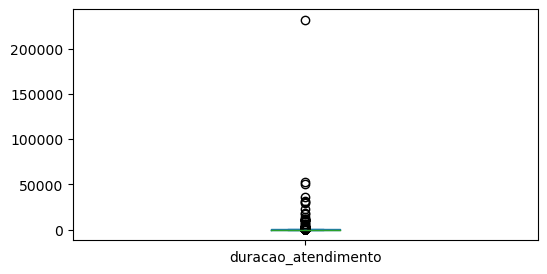

In [71]:
# boxplot de "duracao_atendimento"
df_02['duracao_atendimento'].plot.box()

In [73]:
# inspeção dos maiores outliers superiores 
df_02.sort_values(by='duracao_atendimento', ascending=False).head(150)

,Unnamed: 0,nascimento,sexo,data_entrada,data_saida,tipo_atendimento,tipo_passagem,procedimento_cirurgico,especialidade_procedimento,tecnica_cirurgica,potencial_contaminacao,porte,medico,especialidade_cirurgiao,asa,intercorrencia_intraop,tipo_intercorrencia_intraop,idade,duracao_atendimento,turno
8234,8234,1985-10-04,Feminino,2020-02-01 16:57:06,2020-07-11 18:31:42,Clinica Cirurgica,INTERNADO,"Retirada de fios, pinos, parafusos ou hastes m...",Ortopedia,Não Informado,CLASSE I - LIMPA,P1,Ryan Nunes,ORTOPEDIA E TRAUMATOLOGIA,I,Não,Não Informado,35,231934.6,Tarde
48,48,1962-03-31,Masculino,2019-01-09 10:15:08,2019-02-14 23:19:25,Clinica Cirurgica,INTERNADO,Prostatavesiculectomia radical laparoscópica,Urologia,Robótica,CLASSE II - POTENCIALMENTE CONTAMINADA,P6,Caio da Mota,UROLOGIA,II,Não,Não Informado,57,52624.3,Manhã
20617,20617,2017-12-27,Feminino,2020-02-14 17:31:46,2020-03-20 18:39:01,Pediatria,INTERNADO,Implante cirúrgico de cateter de longa permanê...,Cirurgia Vascular,Convencional,CLASSE I - LIMPA,P2,Vitor Viana,CIRURGIA VASCULAR,IV,Não,Não Informado,3,50467.2,Tarde
7532,7532,1983-09-12,Masculino,2020-09-26 08:24:04,2020-10-21 10:10:55,Clinica Medica,INTERNADO,Apendicectomia por videolaparoscopia,Cirurgia Geral,Não Informado,CLASSE II - POTENCIALMENTE CONTAMINADA,P3,Luiz Otávio Lima,CIRURGIA GERAL,II,Não,Não Informado,37,36106.8,Manhã
889,889,1942-04-13,Masculino,2019-08-10 07:08:41,2019-09-01 09:11:36,Clinica Cirurgica,INTERNADO,Ressecção endoscópica da próstata,Urologia,Não Informado,CLASSE II - POTENCIALMENTE CONTAMINADA,P3,Maria Julia Farias,UROLOGIA,II,Não,Não Informado,77,31802.9,Manhã
2458,2458,1961-06-16,Masculino,2019-10-04 07:10:18,2019-10-25 08:14:56,Clinica Cirurgica,INTERNADO,"Hemorroidectomia aberta ou fechada, com ou sem...",Proctologia,Convencional,CLASSE II - POTENCIALMENTE CONTAMINADA,P3,Cauê da Mota,CIRURGIA GERAL,II,Não,Não Informado,58,30304.6,Manhã
15940,15940,1959-04-20,Feminino,2019-03-08 14:18:43,2019-03-28 19:56:09,Clinica Cirurgica,INTERNADO,"Hemiatrofia facial, correção com enxerto de go...",Neurocirurgia,Não Informado,CLASSE I - LIMPA,P3,Ana Vitória Fogaça,CIRURGIA PLÁSTICA,II,Não,Não Informado,60,29137.4,Tarde
7630,7630,1968-12-08,Masculino,2020-10-07 14:39:16,2020-10-23 17:21:17,Clinica Cirurgica,INTERNADO,Implante de prótese semi-rígida (exclui prótes...,Urologia,Convencional,CLASSE I - LIMPA,P3,Srta. Nicole Lopes,UROLOGIA,II,Não,Não Informado,52,23202.0,Tarde
11210,11210,2005-02-12,Masculino,2019-07-07 07:02:20,2019-07-20 08:27:18,Clinica Cirurgica,INTERNADO,Postectomia,Urologia,Convencional,CLASSE I - LIMPA,P0,João Miguel Cunha,CIRURGIA PEDIATRICA,I,Não,Não Informado,14,18805.0,Manhã
27466,27466,1984-11-02,Feminino,2019-03-08 13:00:10,2019-03-20 20:17:33,Obstetricia,INTERNADO,Versão cefálica externa,Ginecologia e Obstetrícia,Convencional,CLASSE I - LIMPA,Não Informado,Sr. Cauã Monteiro,GINECOLOGIA E OBSTETRÍCIA,II,Não,Não Informado,35,17717.4,Tarde


**df_02**

- criação das variáveis 'duracao_cirurgia' e 'turno';
- remoção de 'duracao_atendimento' negativos;

In [77]:
# volumetria dos atendimentos por especialidade
df_02['especialidade_procedimento'].value_counts()

especialidade_procedimento
Ginecologia e Obstetrícia              8623
Cirurgia Geral                         5099
Urologia                               4030
Plástica                               1990
Cirurgia Vascular                      1894
Oftalmologia                           1874
Ortopedia                              1756
Não Informado                          1471
Dermatologia/Plástica                   979
Cabeça e Pescoço                        754
Otorrinolaringologia                    686
Proctologia                             580
Neurocirurgia                           538
Anestesiologia                          507
Dermatologia                            501
Cardiovascular                          326
Cirurgia Torácica                       301
Ortopedia/Neurocirurgia                 240
Neurocirurgia/Ortopedia                 159
Mastologia                              127
Cirurgia Pediátrica                     108
Cirurgia Plástica                       101
Outra

- Por conta da alta variabilidade da duração do atendimento cirúrgico e com a finalidade de uma análise mais interpretável e delimitada em termos de procedimentos, foi escolhida a especialidade "Urologia", uma vez que apresenta uma das maiores volumetrias do conjunto de dados.
- Foi definido o intervalo de 30 a 480 minutos (1/2 a 8 horas, respectivamente), com base nas convenções de porte de cirurgia.

In [96]:
# criação de dataframe apenas com os atendimentos em Urologia
df_02_uro = df_02[df_02['especialidade_procedimento']=='Urologia']
df_02_uro.describe()

,Unnamed: 0,nascimento,data_entrada,data_saida,idade,duracao_atendimento
count,4030.000000,4030,4030,4030,4030.000000,4030.000000
mean,14397.593548,1975-09-03 12:04:17.270471488,2019-11-17 09:35:03.144913408,2019-11-17 11:45:32.332506112,44.218859,130.486923
min,9.000000,1921-04-24 00:00:00,2019-01-03 15:34:10,2019-01-03 16:45:28,0.000000,1.700000
25%,7906.750000,1957-10-11 12:00:00,2019-06-04 15:01:57.750000128,2019-06-04 16:07:28.500000,33.000000,52.000000
50%,14266.500000,1975-04-16 12:00:00,2019-11-03 07:31:19.500000,2019-11-03 08:31:38,45.000000,69.300000
75%,19689.500000,1986-08-03 00:00:00,2020-04-05 09:56:32,2020-04-05 11:13:39.750000128,62.000000,102.700000
max,35492.000000,2020-11-01 00:00:00,2020-11-02 07:34:34,2020-11-02 11:18:01,98.000000,52624.300000
std,8331.570637,NaN,NaN,NaN,23.769279,1117.787439


In [98]:
df_02_uro.head()

,Unnamed: 0,nascimento,sexo,data_entrada,data_saida,tipo_atendimento,tipo_passagem,procedimento_cirurgico,especialidade_procedimento,tecnica_cirurgica,potencial_contaminacao,porte,medico,especialidade_cirurgiao,asa,intercorrencia_intraop,tipo_intercorrencia_intraop,idade,duracao_atendimento,turno
9,9,1954-10-08,Masculino,2019-01-11 06:04:33,2019-01-11 08:59:00,Clinica Cirurgica,INTERNADO,Prostatavesiculectomia radical laparoscópica,Urologia,Robótica,CLASSE II - POTENCIALMENTE CONTAMINADA,P6,Dr. Joaquim Castro,UROLOGIA,II,Não,Não Informado,65,174.4,Manhã
14,14,1936-11-14,Masculino,2019-01-04 10:24:50,2019-01-04 12:36:29,Clinica Cirurgica,INTERNADO,Ressecção endoscópica da próstata,Urologia,Vídeo,CLASSE II - POTENCIALMENTE CONTAMINADA,P3,João Lucas da Luz,UROLOGIA,II,Não,Não Informado,83,131.6,Manhã
16,16,1991-03-18,Masculino,2019-01-13 19:21:53,2019-01-13 22:06:34,Clinica Cirurgica,INTERNADO,Varicocele unilateral - correção cirúrgica,Urologia,Convencional,CLASSE I - LIMPA,P1,Leandro da Rocha,UROLOGIA,I,Não,Não Informado,28,164.7,Noite
20,20,2018-01-25,Masculino,2019-01-12 11:07:16,2019-01-12 12:23:46,Cirurgia Day Clinic,INTERNADO,Orquidopexia unilateral,Urologia,Convencional,CLASSE I - LIMPA,P2,Nicole da Rosa,CIRURGIA PEDIATRICA,I,Não,Não Informado,1,76.5,Manhã
21,21,1978-02-12,Masculino,2019-01-06 05:57:12,2019-01-06 07:11:03,Day Clinic,EXTERNO,Cirurgia esterilizadora masculina,Urologia,Convencional,CLASSE I - LIMPA,P1,Brenda da Rosa,UROLOGIA,II,Não,Não Informado,41,73.8,Madrugada


<Axes: ylabel='Frequency'>

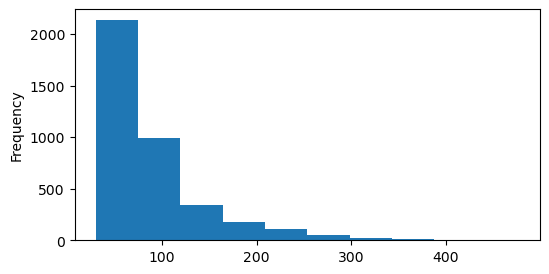

In [106]:
# definição do intervalo da duração de atendimento
min_duracao = 30   
max_duracao = 480  

# criação de DataFrame com o intervalo de "duracao_atendimento" definido
df_02_uro = df_02_uro[(df_02_uro['duracao_atendimento'] >= min_duracao) & (df_02_uro['duracao_atendimento'] <= max_duracao)]
df_02_uro['duracao_atendimento'].plot.hist()

- Constata-se que a variável-alvo apresenta uma distribuição não-Normal, assimétrica para direita.

In [114]:
# volumetria após filtragens de "especialidade" e "duracao_atendimento"
print(f'Quantidade de linhas: {df_02_uro.shape[0]}')

Quantidade de linhas: 3864


In [116]:
# descritiva de "duracao_atendimento" filtrada
df_02_uro['duracao_atendimento'].describe()

count    3864.000000
mean       89.722412
std        58.438063
min        30.000000
25%        54.000000
50%        69.750000
75%       104.300000
max       476.800000
Name: duracao_atendimento, dtype: float64

- Verificou-se os procedimentos cirúrgicos em Urologia a fim de identificar a representatividade das classes.

In [226]:
df_02_uro['procedimento_cirurgico'].value_counts()

procedimento_cirurgico
Postectomia                                                                                             665
Cirurgia esterilizadora masculina                                                                       552
Retirada endoscópica de duplo J                                                                         473
Ressecção endoscópica da próstata                                                                       286
Vasectomia unilateral                                                                                   221
Tumor vesical - ressecção endoscópica                                                                   216
Prostatavesiculectomia radical laparoscópica                                                            163
Biópsia endoscópica de bexiga (inclui cistoscopia)                                                      128
Colocação cistoscópica de duplo J unilateral                                                            104
Cisto

- Definiu-se pela remoção dos procedimentos raros (< 0,026% dos dados), já que podem ser fonte de ruído no processo de agrupamento.

In [125]:
# Contar o número de ocorrências de cada classe na coluna 'procedimento_cirurgico'
classe_counts = df_02_uro['procedimento_cirurgico'].value_counts()

# Identificar as classes que aparecem em menos de 100 linhas
classes_baixas = classe_counts[classe_counts < 10].index

# Filtrar o DataFrame para remover as linhas com essas classes
df_uro_filt = df_02_uro[~df_02_uro['procedimento_cirurgico'].isin(classes_baixas)]

# Exibir o DataFrame filtrado
df_uro_filt['procedimento_cirurgico'].value_counts()

procedimento_cirurgico
Postectomia                                                         665
Cirurgia esterilizadora masculina                                   552
Retirada endoscópica de duplo J                                     473
Ressecção endoscópica da próstata                                   286
Vasectomia unilateral                                               221
Tumor vesical - ressecção endoscópica                               216
Prostatavesiculectomia radical laparoscópica                        163
Biópsia endoscópica de bexiga (inclui cistoscopia)                  128
Colocação cistoscópica de duplo J unilateral                        104
Cistoscopia e/ou uretroscopia                                        95
Colocação ureteroscópica de duplo J unilateral                       85
Corpo estranho - extração endoscópica                                80
Varicocele unilateral - correção cirúrgica                           71
Nefrectomia parcial laparoscópica unilate

In [128]:
# Calcular a média e o desvio padrão para a coluna 'valor' para cada procedimento
uro_media_dp = df_uro_filt.groupby('procedimento_cirurgico')['duracao_atendimento'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para melhor legibilidade
uro_media_dp.columns = ['procedimento_cirurgico', 'media_valor', 'desvio_padrao_valor']


In [130]:
uro_media_dp.shape

(33, 3)

In [132]:
uro_media_dp.sort_values(by=['media_valor', 'desvio_padrao_valor'], ascending=False)

,procedimento_cirurgico,media_valor,desvio_padrao_valor
26,Transplante renal (receptor),248.243750,55.844307
19,Prostatavesiculectomia radical,244.676471,82.971844
15,Nefrectomia radical laparoscópica unilateral,234.520000,66.494758
1,Adrenalectomia laparoscópica unilateral,215.345455,46.396215
21,Prostatectomia a céu aberto,210.524242,61.156495
20,Prostatavesiculectomia radical laparoscópica,207.947853,60.471732
14,Nefrectomia parcial laparoscópica unilateral,204.936364,62.338879
13,Implante de prótese semi-rígida (exclui prótes...,141.966667,51.009127
0,Ablação prostática a laser,130.715385,36.055371
22,Ressecção endoscópica da próstata,128.668881,44.829274


Text(0, 0.5, 'Desvio Padrão do Valor')

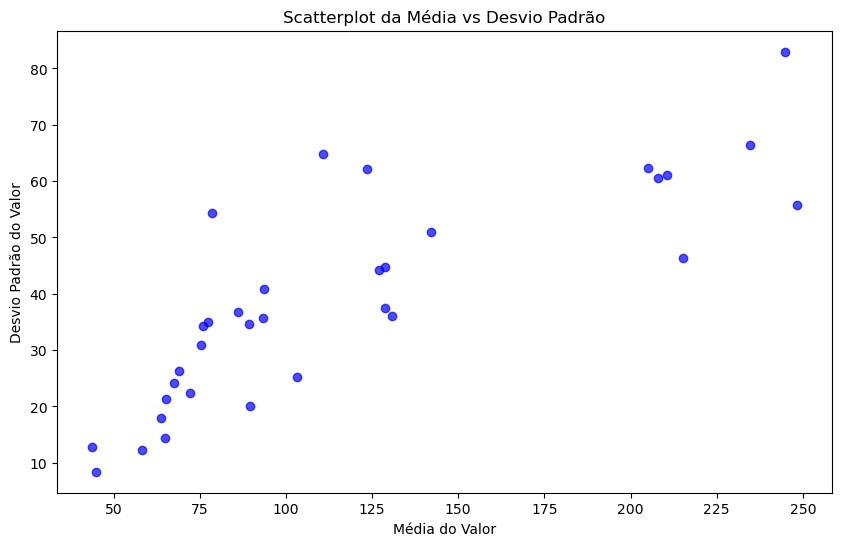

In [134]:
# Criar o scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(uro_media_dp['media_valor'], uro_media_dp['desvio_padrao_valor'], color='blue', alpha=0.7)

# Adicionar títulos e rótulos aos eixos
plt.title('Scatterplot da Média vs Desvio Padrão')
plt.xlabel('Média do Valor')
plt.ylabel('Desvio Padrão do Valor')

### Criação dos grupos

In [137]:
# Aplicando e Calculando a Distância de Gower
gower_dist = gower_matrix(uro_media_dp)
gower_dist.shape

(33, 33)

In [145]:
def perform_pam_clustering(diss_matrix, n_clusters):
    kmedoids_model = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=0, method='pam').fit(diss_matrix)
    labels = kmedoids_model.fit_predict(diss_matrix)
    silhouette_avg = silhouette_score(diss_matrix, labels, metric='precomputed')
    return silhouette_avg, labels

In [147]:
silhouette_scores = []

# iteração 
for n_clusters in range(2, 11):
    silhouette_avg = perform_pam_clustering(gower_dist, n_clusters)[0]
    silhouette_scores.append(silhouette_avg)

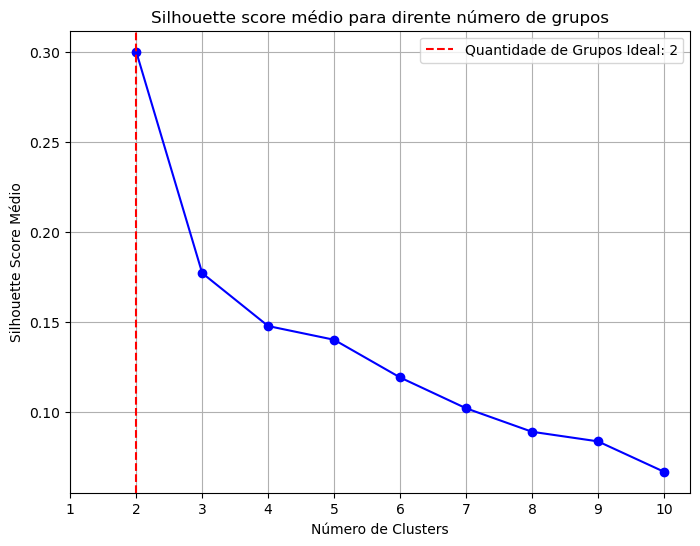

In [149]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score Médio')
plt.title('Silhouette score médio para dirente número de grupos')
plt.xticks(range(1, 11))
plt.grid(True)

best_n_clusters = np.argmax(silhouette_scores) + 2 # +2 é o ajuste necessário para que o índice 4 represente o k=6
plt.axvline(x=best_n_clusters, color='r', linestyle='--', label=f'Quantidade de Grupos Ideal: {best_n_clusters}')
plt.legend()
plt.show()

- Apesar do *silhouette score* ter indicado 2 grupos, a inspeção visual do gráfico sugere que pode haver mais de 2 grupos. Além disso, o agrupamento em dois clusters levaria a uma simplificação/generalização excessiva, empobrecendo a interpretabilidade da análise. Assim, foi definido um n=4 clusters.

In [154]:
df_cluster = uro_media_dp.copy()
n_cluster = 4
df_cluster['CLUSTER'] = perform_pam_clustering(gower_dist, n_cluster)[1]
df_cluster.head(10)

,procedimento_cirurgico,media_valor,desvio_padrao_valor,CLUSTER
0,Ablação prostática a laser,130.715385,36.055371,3
1,Adrenalectomia laparoscópica unilateral,215.345455,46.396215,2
2,Aspiração manual intra-uterina (AMIU),58.302941,12.245110,1
3,Biópsia endoscópica de bexiga (inclui cistosco...,63.682031,17.961737,1
4,Cirurgia esterilizadora masculina,64.812319,14.385689,1
5,Cistoscopia e/ou uretroscopia,76.061053,34.353702,0
6,Colocação cirúrgica de duplo J unilateral,67.384615,24.136999,1
7,Colocação cistoscópica de duplo J unilateral,75.398077,30.880405,0
8,Colocação ureteroscópica de duplo J unilateral,68.883529,26.303552,1
9,Corpo estranho - extração endoscópica,45.012500,8.418581,1


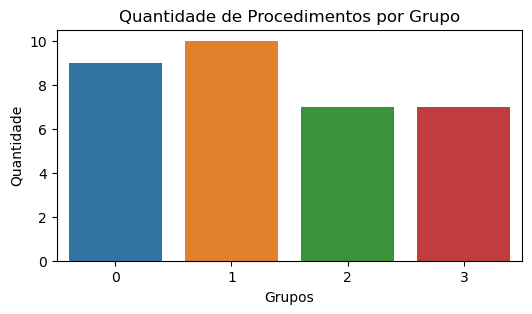

In [156]:
# gráfico de barra com a quantidade de procedimentos por grupo
clusters_size = df_cluster['CLUSTER'].value_counts()
sns.barplot(x=clusters_size.index, y=clusters_size.values)
plt.title('Quantidade de Procedimentos por Grupo')
plt.xlabel('Grupos')
plt.ylabel('Quantidade')
plt.show()

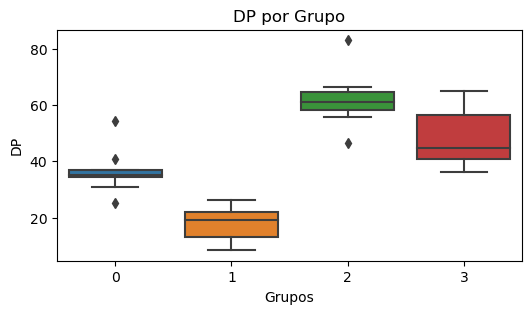

In [158]:
pp = df_cluster[['CLUSTER','desvio_padrao_valor']]

sns.boxplot(x='CLUSTER', y='desvio_padrao_valor', data=pp)

plt.xlabel('Grupos')
plt.ylabel('DP')
plt.title('DP por Grupo')
plt.show()

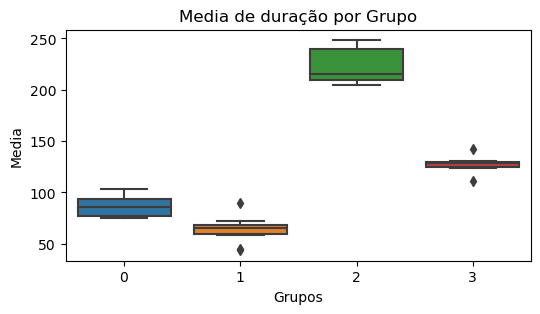

In [160]:
pp = df_cluster[['CLUSTER','media_valor']]

sns.boxplot(x='CLUSTER', y='media_valor', data=pp)

plt.xlabel('Grupos')
plt.ylabel('Media')
plt.title('Media de duração por Grupo')
plt.show()

In [164]:
df_03_uro = df_02_uro.copy()

In [168]:
# inclusão da coluna 'Cluster' no DataFrame
df_03_uro = pd.merge(df_03_uro, df_cluster, on='procedimento_cirurgico', how='left')
df_03_uro.head()

,Unnamed: 0,nascimento,sexo,data_entrada,data_saida,tipo_atendimento,tipo_passagem,procedimento_cirurgico,especialidade_procedimento,tecnica_cirurgica,potencial_contaminacao,porte,medico,especialidade_cirurgiao,asa,intercorrencia_intraop,tipo_intercorrencia_intraop,idade,duracao_atendimento,turno,media_valor,desvio_padrao_valor,CLUSTER
0,9,1954-10-08,Masculino,2019-01-11 06:04:33,2019-01-11 08:59:00,Clinica Cirurgica,INTERNADO,Prostatavesiculectomia radical laparoscópica,Urologia,Robótica,CLASSE II - POTENCIALMENTE CONTAMINADA,P6,Dr. Joaquim Castro,UROLOGIA,II,Não,Não Informado,65,174.4,Manhã,207.947853,60.471732,2.0
1,14,1936-11-14,Masculino,2019-01-04 10:24:50,2019-01-04 12:36:29,Clinica Cirurgica,INTERNADO,Ressecção endoscópica da próstata,Urologia,Vídeo,CLASSE II - POTENCIALMENTE CONTAMINADA,P3,João Lucas da Luz,UROLOGIA,II,Não,Não Informado,83,131.6,Manhã,128.668881,44.829274,3.0
2,16,1991-03-18,Masculino,2019-01-13 19:21:53,2019-01-13 22:06:34,Clinica Cirurgica,INTERNADO,Varicocele unilateral - correção cirúrgica,Urologia,Convencional,CLASSE I - LIMPA,P1,Leandro da Rocha,UROLOGIA,I,Não,Não Informado,28,164.7,Noite,128.642254,37.476121,3.0
3,20,2018-01-25,Masculino,2019-01-12 11:07:16,2019-01-12 12:23:46,Cirurgia Day Clinic,INTERNADO,Orquidopexia unilateral,Urologia,Convencional,CLASSE I - LIMPA,P2,Nicole da Rosa,CIRURGIA PEDIATRICA,I,Não,Não Informado,1,76.5,Manhã,93.603704,40.823932,0.0
4,21,1978-02-12,Masculino,2019-01-06 05:57:12,2019-01-06 07:11:03,Day Clinic,EXTERNO,Cirurgia esterilizadora masculina,Urologia,Convencional,CLASSE I - LIMPA,P1,Brenda da Rosa,UROLOGIA,II,Não,Não Informado,41,73.8,Madrugada,64.812319,14.385689,1.0


In [170]:
df_03_uro.drop(['media_valor', 'desvio_padrao_valor'], axis=1, inplace=True)
df_03_uro.head()

,Unnamed: 0,nascimento,sexo,data_entrada,data_saida,tipo_atendimento,tipo_passagem,procedimento_cirurgico,especialidade_procedimento,tecnica_cirurgica,potencial_contaminacao,porte,medico,especialidade_cirurgiao,asa,intercorrencia_intraop,tipo_intercorrencia_intraop,idade,duracao_atendimento,turno,CLUSTER
0,9,1954-10-08,Masculino,2019-01-11 06:04:33,2019-01-11 08:59:00,Clinica Cirurgica,INTERNADO,Prostatavesiculectomia radical laparoscópica,Urologia,Robótica,CLASSE II - POTENCIALMENTE CONTAMINADA,P6,Dr. Joaquim Castro,UROLOGIA,II,Não,Não Informado,65,174.4,Manhã,2.0
1,14,1936-11-14,Masculino,2019-01-04 10:24:50,2019-01-04 12:36:29,Clinica Cirurgica,INTERNADO,Ressecção endoscópica da próstata,Urologia,Vídeo,CLASSE II - POTENCIALMENTE CONTAMINADA,P3,João Lucas da Luz,UROLOGIA,II,Não,Não Informado,83,131.6,Manhã,3.0
2,16,1991-03-18,Masculino,2019-01-13 19:21:53,2019-01-13 22:06:34,Clinica Cirurgica,INTERNADO,Varicocele unilateral - correção cirúrgica,Urologia,Convencional,CLASSE I - LIMPA,P1,Leandro da Rocha,UROLOGIA,I,Não,Não Informado,28,164.7,Noite,3.0
3,20,2018-01-25,Masculino,2019-01-12 11:07:16,2019-01-12 12:23:46,Cirurgia Day Clinic,INTERNADO,Orquidopexia unilateral,Urologia,Convencional,CLASSE I - LIMPA,P2,Nicole da Rosa,CIRURGIA PEDIATRICA,I,Não,Não Informado,1,76.5,Manhã,0.0
4,21,1978-02-12,Masculino,2019-01-06 05:57:12,2019-01-06 07:11:03,Day Clinic,EXTERNO,Cirurgia esterilizadora masculina,Urologia,Convencional,CLASSE I - LIMPA,P1,Brenda da Rosa,UROLOGIA,II,Não,Não Informado,41,73.8,Madrugada,1.0


In [172]:
# contagem de atendimentos cirúrgicos por cluster
df_03_uro['CLUSTER'].value_counts()

CLUSTER
1.0    2265
0.0     569
3.0     452
2.0     316
Name: count, dtype: int64

In [177]:
cluster_1['procedimento_cirurgico'].value_counts()

procedimento_cirurgico
Postectomia                                           665
Cirurgia esterilizadora masculina                     552
Retirada endoscópica de duplo J                       473
Vasectomia unilateral                                 221
Biópsia endoscópica de bexiga (inclui cistoscopia)    128
Colocação ureteroscópica de duplo J unilateral         85
Corpo estranho - extração endoscópica                  80
Aspiração manual intra-uterina (AMIU)                  34
Torção de testículo - cura cirúrgica                   14
Colocação cirúrgica de duplo J unilateral              13
Name: count, dtype: int64

### Seleção e codificação das variáveis para o modelo preditivo

**Variáveis removidas:**
- _tipo_atendimento_: está correlacionado ao procedimento cirurgico (redundância), o que pode adicionar multicolinearidade;
- _procedimento_cirurgico_: foi utilizado para os clusters e não tem valor preditivo;
- _tipo_passagem_: classes muito desbalanceadas;
- _interocorrencia_intraop_: embora bastante relacionada com a duração das cirurgias, ocorre após o agendamento e as classes estão bastante desbalanceadas;;
- _tipo_interocorrencia_intraop_: idem item anterior;
- _especialidade_: variável utilizada para definir o conjunto amostral (Urologia);
- _asa_: definido apenas no momento da cirurgia (pós-agendamento).

**Variáveis mantidas:**
- _sexo_;
- _idade_;
- _tecnica_cirurgica_;
- _potencial_contaminacao_;
- _turno_;
- _tipo_intercorrencia_intraop_;
- _CLUSTER_ (apenas para dividir os datasets codificados).

In [189]:
df_04_uro = df_03_uro.copy()

In [191]:
colunas_modelo = ['sexo', 'idade', 'tecnica_cirurgica', 'potencial_contaminacao', 'turno', 'duracao_atendimento', 'CLUSTER']

In [193]:
df_04_uro = df_04_uro[colunas_modelo]
df_04_uro.head()

,sexo,idade,tecnica_cirurgica,potencial_contaminacao,turno,duracao_atendimento,CLUSTER
0,Masculino,65,Robótica,CLASSE II - POTENCIALMENTE CONTAMINADA,Manhã,174.4,2.0
1,Masculino,83,Vídeo,CLASSE II - POTENCIALMENTE CONTAMINADA,Manhã,131.6,3.0
2,Masculino,28,Convencional,CLASSE I - LIMPA,Noite,164.7,3.0
3,Masculino,1,Convencional,CLASSE I - LIMPA,Manhã,76.5,0.0
4,Masculino,41,Convencional,CLASSE I - LIMPA,Madrugada,73.8,1.0


In [249]:
# mediana de duracao_atendimento por sexo
df_04_uro.groupby('sexo')['duracao_atendimento'].median()

sexo
Feminino     62.25
Masculino    72.20
Name: duracao_atendimento, dtype: float64

In [245]:
# contagem dos sexos
df_04_uro['sexo'].value_counts()

sexo
Masculino    3292
Feminino      572
Name: count, dtype: int64

In [236]:
# mediana de duracao_atendimento por sexo
df_04_uro.groupby('turno')['duracao_atendimento'].median()

turno
Madrugada    79.05
Manhã        71.40
Tarde        69.65
Noite        64.15
Name: duracao_atendimento, dtype: float64

In [228]:
# mediana de duracao_atendimento por sexo
df_04_uro.groupby('potencial_contaminacao')['duracao_atendimento'].median()

potencial_contaminacao
CLASSE I - LIMPA                           68.85
CLASSE II - POTENCIALMENTE CONTAMINADA     74.70
CLASSE III - CONTAMINADA                   52.60
CLASSE IV - INFECTADA                     107.05
Name: duracao_atendimento, dtype: float64

In [260]:
df_04_uro['tecnica_cirurgica'].value_counts()

tecnica_cirurgica
Convencional     1596
Vídeo            1380
Não Informado     659
Robótica          229
Name: count, dtype: int64

In [262]:
# mediana de duracao_atendimento por sexo
df_04_uro.groupby('tecnica_cirurgica')['duracao_atendimento'].std()

tecnica_cirurgica
Convencional     47.537560
Não Informado    44.953421
Robótica         60.881144
Vídeo            54.875905
Name: duracao_atendimento, dtype: float64

<Axes: xlabel='idade', ylabel='duracao_atendimento'>

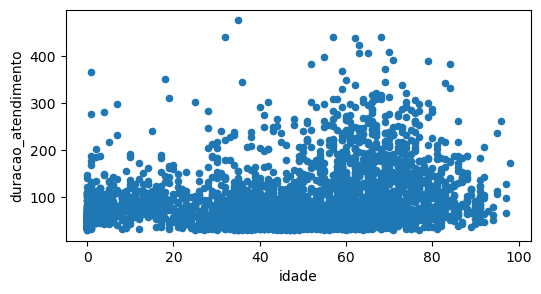

In [222]:
df_04_uro.plot.scatter(x='idade', y='duracao_atendimento')

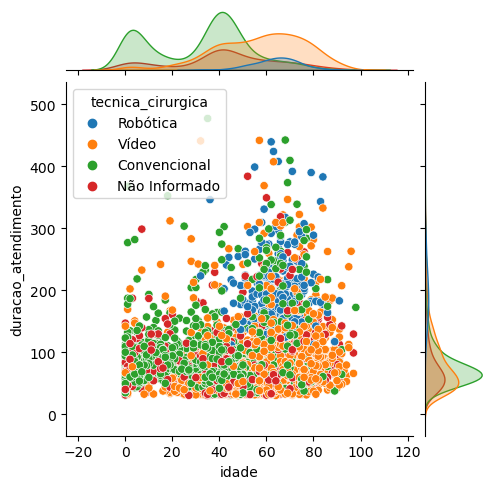

In [257]:
# relacionamento de duracao_atendimento com 'idade' e 'tecnica_cirurgica'
sns.jointplot(x='idade', y='duracao_atendimento', data=df_04_uro, 
              kind='scatter', hue='tecnica_cirurgica', 
              height=5)

Da Análise Exploratória dos dados preparados, depreende-se que há muito mais atendimentos do sexo masculino em relação ao feminino. Contudo, ambos apresentam o mesmo desvio-padrão em relação à duração do atendimento (variável de interesse). 

A idade, em todo o seu intervalo (cerca de 0 a 100 anos), não aparenta ter linearidade com a duração do atendimento. Quando variáveis como turno e técnica cirúrgica são incluídas na relação, a formação de grupos (jovens/adultos-convencional; idosos/vídeo e idosos/robótica) é evidente.

### Codificação
- Todas as variáveis preditoras são qualitativas e consideradas nominais para o modelo, portanto, codificadas pela técnica de _One-Hot Encoding_;
- Sexo masculino foi considerado como 1, já que tem mais representatividade e maior mediana em relação à duração do atendimento;
- Algumas dummies foram dropadas, como 'Não Informado' (referente à técnica_cirurgica).....

In [198]:
colunas_dummies = ['sexo', 'tecnica_cirurgica', 'potencial_contaminacao', 'turno']

In [267]:
# criação do DataFrame com dummies
df_05_uro = pd.get_dummies(df_04_uro, columns=colunas_dummies, drop_first=False, dtype=int)
df_05_uro.head()

,idade,duracao_atendimento,CLUSTER,sexo_Feminino,sexo_Masculino,tecnica_cirurgica_Convencional,tecnica_cirurgica_Não Informado,tecnica_cirurgica_Robótica,tecnica_cirurgica_Vídeo,potencial_contaminacao_CLASSE I - LIMPA,potencial_contaminacao_CLASSE II - POTENCIALMENTE CONTAMINADA,potencial_contaminacao_CLASSE III - CONTAMINADA,potencial_contaminacao_CLASSE IV - INFECTADA,turno_Madrugada,turno_Manhã,turno_Tarde,turno_Noite
0,65,174.4,2.0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,83,131.6,3.0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
2,28,164.7,3.0,0,1,1,0,0,0,1,0,0,0,0,0,0,1
3,1,76.5,0.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
4,41,73.8,1.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0


In [271]:
df_05_uro.drop(['sexo_Feminino', 'tecnica_cirurgica_Não Informado'], axis=1, inplace=True)
df_05_uro.head()

,idade,duracao_atendimento,CLUSTER,sexo_Masculino,tecnica_cirurgica_Convencional,tecnica_cirurgica_Robótica,tecnica_cirurgica_Vídeo,potencial_contaminacao_CLASSE I - LIMPA,potencial_contaminacao_CLASSE II - POTENCIALMENTE CONTAMINADA,potencial_contaminacao_CLASSE III - CONTAMINADA,potencial_contaminacao_CLASSE IV - INFECTADA,turno_Madrugada,turno_Manhã,turno_Tarde,turno_Noite
0,65,174.4,2.0,1,0,1,0,0,1,0,0,0,1,0,0
1,83,131.6,3.0,1,0,0,1,0,1,0,0,0,1,0,0
2,28,164.7,3.0,1,1,0,0,1,0,0,0,0,0,0,1
3,1,76.5,0.0,1,1,0,0,1,0,0,0,0,1,0,0
4,41,73.8,1.0,1,1,0,0,1,0,0,0,1,0,0,0


In [273]:
col_names = {'sexo_Masculino' : 'sexo_M', 
             'tecnica_cirurgica_Convencional' : 'tecnica_C', 
             'tecnica_cirurgica_Robótica' : 'tecnica_R', 
             'tecnica_cirurgica_Vídeo' : 'tecnica_V', 
             'potencial_contaminacao_CLASSE I - LIMPA' : 'contaminacao_1',
             'potencial_contaminacao_CLASSE II - POTENCIALMENTE CONTAMINADA' : 'contaminacao_2', 
             'potencial_contaminacao_CLASSE III - CONTAMINADA' : 'contaminacao_3', 
             'potencial_contaminacao_CLASSE IV - INFECTADA' : 'contaminacao_4', 
             'turno_Madrugada' : 'turno_Mad', 
             'turno_Manhã' : 'turno_Man', 
             'turno_Tarde' : 'turno_Tar', 
             'turno_Noite' : 'turno_Noi'}

df_05_uro.rename(col_names, axis=1, inplace=True)
df_05_uro.head()

,idade,duracao_atendimento,CLUSTER,sexo_M,tecnica_C,tecnica_R,tecnica_V,contaminacao_1,contaminacao_2,contaminacao_3,contaminacao_4,turno_Mad,turno_Man,turno_Tar,turno_Noi
0,65,174.4,2.0,1,0,1,0,0,1,0,0,0,1,0,0
1,83,131.6,3.0,1,0,0,1,0,1,0,0,0,1,0,0
2,28,164.7,3.0,1,1,0,0,1,0,0,0,0,0,0,1
3,1,76.5,0.0,1,1,0,0,1,0,0,0,0,1,0,0
4,41,73.8,1.0,1,1,0,0,1,0,0,0,1,0,0,0


In [289]:
# criação dos datasets segundo os clusters
cluster_0 = df_05_uro[df_05_uro['CLUSTER']==0.0]
cluster_1 = df_05_uro[df_05_uro['CLUSTER']==1.0]
cluster_2 = df_05_uro[df_05_uro['CLUSTER']==2.0]
cluster_3 = df_05_uro[df_05_uro['CLUSTER']==3.0]

In [291]:
# removendo a coluna 'CLUSTERS'
clusters = [cluster_0, cluster_1, cluster_2, cluster_3]

for c in clusters:
    c.drop('CLUSTER', axis=1, inplace=True)
    c.head(1)

C:\Users\User\AppData\Local\Temp\ipykernel_3040\2144799514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c.drop('CLUSTER', axis=1, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_3040\2144799514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c.drop('CLUSTER', axis=1, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_3040\2144799514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c.drop('CLUSTER', axis=1, 

## Modelagem e Avaliação

### CLUSTER 0 - cerca de 1h25 +- 35 m

In [399]:
print('------PROCEDIMENTOS CLUSTER 0:')
df_03_uro[df_03_uro['CLUSTER']==0.0]['procedimento_cirurgico'].value_counts()

------PROCEDIMENTOS CLUSTER 0:


procedimento_cirurgico
Tumor vesical - ressecção endoscópica                216
Colocação cistoscópica de duplo J unilateral         104
Cistoscopia e/ou uretroscopia                         95
Uretrotomia interna                                   38
Hidrocele unilateral - correção cirúrgica             31
Orquidopexia unilateral                               27
Doença de Peyronie - tratamento cirúrgico             21
Orquiectomia unilateral                               19
Ureterorrenolitotripsia rígida unilateral a laser     18
Name: count, dtype: int64

In [401]:
# divisão entre target e preditoras
X_0 = cluster_0.drop(['duracao_atendimento'], axis=1)
y_0 = cluster_0['duracao_atendimento']

In [403]:
# amostram holdout
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, test_size=0.25, random_state=1)

In [405]:
# Estimando os Coeficientes
model = LinearRegression().fit(X_train, y_train)
print('CLUSTER 0 \n')
print('intercept:', model.intercept_)

# Valores preditos pelo modelo
y_pred = model.predict(X_test)

# Calcula o RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('rmse.....:', rmse)

# Calcula o R2 (R-squared)
r2 = r2_score(y_test, y_pred)
print('r2.......:', r2)

# Calcula o R2 ajustado (adjusted R-squared)
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1-((n-1)/(n-(p+1)))*(1-r2_score(y_test, y_pred))
print('r2_adj...:', r2_adj)

CLUSTER 0 

intercept: 71.58963915292138
rmse.....: 32.41333508175257
r2.......: 0.004572971472881937
r2_adj...: -0.09574138023915313


In [407]:
print('Coeficientes angulares do CLUSTER 0: \n')
for feature, coef in zip(cluster_0.columns, model.coef_):
    if feature == 'duracao_atendimento':
        continue
    print(f"{feature}: {coef}")

Coeficientes angulares do CLUSTER 0: 

idade: 0.10997266017370406
sexo_M: 2.4757525181808866
tecnica_C: 3.552713678800501e-15
tecnica_R: 12.822640587555203
tecnica_V: 7.753372604652126
contaminacao_1: -7.753372604652125
contaminacao_2: 4.440892098500626e-16
contaminacao_3: 0.0
contaminacao_4: -1.361448081911423
turno_Mad: -3.5213895855982273
turno_Man: 2.8682693476600667
turno_Tar: 2.0145683198495816


- Sexo Masculino (2.48): Pacientes do sexo masculino tendem a ter cirurgias um pouco mais longas em comparação com mulheres.

- Técnica R (12.82) e Técnica V (7.75): Ambas as técnicas aumentam significativamente a duração da cirurgia, com a "Técnica R" sendo a mais impactante.
Contaminação 1 (-7.75): Reduz a duração da cirurgia, o que pode estar relacionado a uma resposta rápida em situações emergenciais.
Turnos:

- Madrugada (-3.52): Cirurgias realizadas de madrugada tendem a ser mais curtas.

**Conclusão: Neste cluster, a técnica cirúrgica Robótica é o fator mais significativo que aumenta a duração da cirurgia. Além disso, pacientes do sexo masculino e cirurgias realizadas durante o dia tendem a ser um pouco mais longas, enquanto cirurgias durante a madrugada são mais curtas.**

### CLUSTER 1 - cerca de 1h +- 20 m

In [350]:
print('------PROCEDIMENTOS CLUSTER 1:')
df_03_uro[df_03_uro['CLUSTER']==1.0]['procedimento_cirurgico'].value_counts()

------PROCEDIMENTOS CLUSTER 1:


procedimento_cirurgico
Postectomia                                           665
Cirurgia esterilizadora masculina                     552
Retirada endoscópica de duplo J                       473
Vasectomia unilateral                                 221
Biópsia endoscópica de bexiga (inclui cistoscopia)    128
Colocação ureteroscópica de duplo J unilateral         85
Corpo estranho - extração endoscópica                  80
Aspiração manual intra-uterina (AMIU)                  34
Torção de testículo - cura cirúrgica                   14
Colocação cirúrgica de duplo J unilateral              13
Name: count, dtype: int64

In [353]:
# divisão entre target e preditoras
X_1 = cluster_1.drop(['duracao_atendimento'], axis=1)
y_1 = cluster_1['duracao_atendimento']

In [359]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.25, random_state=1)

In [365]:
# Estimando os Coeficientes
model = LinearRegression().fit(X_train, y_train)
print('CLUSTER 1 \n')
print('intercept:', model.intercept_)

# Valores preditos pelo modelo
y_pred = model.predict(X_test)

# Calcula o RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('rmse.....:', rmse)

# Calcula o R2 (R-squared)
r2 = r2_score(y_test, y_pred)
print('r2.......:', r2)

# Calcula o R2 ajustado (adjusted R-squared)
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1-((n-1)/(n-(p+1)))*(1-r2_score(y_test, y_pred))
print('r2_adj...:', r2_adj)

CLUSTER 1 

intercept: 61.4076280922778
rmse.....: 20.871640443817295
r2.......: 0.17854900192826928
r2_adj...: 0.1592382189717909


In [377]:
print('Coeficientes angulares do CLUSTER 1: \n')
for feature, coef in zip(cluster_1.columns, model.coef_):
    if feature == 'duracao_atendimento':
        continue
    print(f"{feature}: {coef}")

Coeficientes angulares do CLUSTER 1: 

idade: 0.03503130526590833
sexo_M: -0.2818984390507654
tecnica_C: 3.552713678800501e-15
tecnica_R: 3.3933793344979484
tecnica_V: 11.21381030648269
contaminacao_1: -11.213810306482692
contaminacao_2: 4.440892098500626e-16
contaminacao_3: 0.0
contaminacao_4: 0.5448543016569949
turno_Mad: 0.42646274177578347
turno_Man: 0.5898054827536114
turno_Tar: -1.561122526186387


- Técnica V (11.21): A técnica cirúrgica "V" aumenta significativamente a duração da cirurgia, indicando maior complexidade.

- Contaminação 1 (-11.21): Este tipo de contaminação reduz drasticamente o tempo de cirurgia, possivelmente devido a intervenções mais rápidas.

- Turno Tarde (-1.56): Cirurgias realizadas à tarde tendem a ser mais curtas.

**Conclusão: A técnica utilizada, e o tipo de contaminação são os fatores mais críticos para a duração da cirurgia.**

### CLUSTER 2 - cerca de 3h45 +- 1h

In [413]:
print('------PROCEDIMENTOS CLUSTER 2:')
df_03_uro[df_03_uro['CLUSTER']==2.0]['procedimento_cirurgico'].value_counts()

------PROCEDIMENTOS CLUSTER 2:


procedimento_cirurgico
Prostatavesiculectomia radical laparoscópica    163
Nefrectomia parcial laparoscópica unilateral     66
Prostatectomia a céu aberto                      33
Prostatavesiculectomia radical                   17
Transplante renal (receptor)                     16
Adrenalectomia laparoscópica unilateral          11
Nefrectomia radical laparoscópica unilateral     10
Name: count, dtype: int64

In [415]:
# divisão entre target e preditoras
X_2 = cluster_2.drop(['duracao_atendimento'], axis=1)
y_2 = cluster_2['duracao_atendimento']

In [417]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.25, random_state=1)

In [419]:
# Estimando os Coeficientes
model = LinearRegression().fit(X_train, y_train)
print('CLUSTER 2 \n')
print('intercept:', model.intercept_)

# Valores preditos pelo modelo
y_pred = model.predict(X_test)

# Calcula o RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('rmse.....:', rmse)

# Calcula o R2 (R-squared)
r2 = r2_score(y_test, y_pred)
print('r2.......:', r2)

# Calcula o R2 ajustado (adjusted R-squared)
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1-((n-1)/(n-(p+1)))*(1-r2_score(y_test, y_pred))
print('r2_adj...:', r2_adj)

CLUSTER 2 

intercept: 188.70068716931985
rmse.....: 69.610764081778
r2.......: -0.05173613080202788
r2_adj...: -0.26208335696243346


In [421]:
print('Coeficientes angulares do CLUSTER 2: \n')
for feature, coef in zip(cluster_2.columns, model.coef_):
    if feature == 'duracao_atendimento':
        continue
    print(f"{feature}: {coef}")

Coeficientes angulares do CLUSTER 2: 

idade: 0.612030705617087
sexo_M: -6.667733060771694
tecnica_C: -34.609919934538055
tecnica_R: 18.524254583536027
tecnica_V: -8.881784197001252e-16
contaminacao_1: -4.440892098500626e-16
contaminacao_2: 3.552713678800501e-15
contaminacao_3: 0.0
contaminacao_4: -17.206941333545355
turno_Mad: 19.657140717260184
turno_Man: 5.481306119692819
turno_Tar: -7.931505503407673


- Sexo Masculino (-6.67): Para pacientes do sexo masculino, a duração da cirurgia tende a ser menor, indicando uma diferença de tempo em comparação com pacientes do sexo feminino.

- Técnica C (-34.61): A técnica "C" reduz significativamente a duração da cirurgia, sendo o fator de maior impacto negativo.
- Técnica R (18.52): A técnica "R" aumenta a duração da cirurgia, indicando maior complexidade ou tempo necessário.

- Madrugada (19.66): Cirurgias realizadas na madrugada têm um aumento expressivo na duração.
- Manhã (5.48): Também há um aumento, embora menor, nas cirurgias realizadas pela manhã.
- Tarde (-7.93): Cirurgias realizadas à tarde tendem a ser mais curtas.

**Conclusão: No Cluster 2, a técnica "C" reduz substancialmente a duração da cirurgia, enquanto a técnica "R" e cirurgias realizadas na madrugada são fatores que aumentam significativamente o tempo cirúrgico. Pacientes mais velhos tendem a ter cirurgias mais longas, enquanto o sexo masculino está associado a procedimentos mais curtos.**

### CLUSTER 3 - cerca de 2h +- 45 m

In [425]:
print('------PROCEDIMENTOS CLUSTER 3:')
df_03_uro[df_03_uro['CLUSTER']==3.0]['procedimento_cirurgico'].value_counts()

------PROCEDIMENTOS CLUSTER 3:


procedimento_cirurgico
Ressecção endoscópica da próstata                                   286
Varicocele unilateral - correção cirúrgica                           71
Ureterorrenolitotripsia flexível a laser unilateral                  27
Implante de prótese semi-rígida (exclui próteses infláveis)          24
Retenção por coágulo - aspiração vesical                             18
Ablação prostática a laser                                           13
Hipospadia distal - tratamento em 1 tempo - tratamento cirúrgico     13
Name: count, dtype: int64

In [427]:
# divisão entre target e preditoras
X_3 = cluster_3.drop(['duracao_atendimento'], axis=1)
y_3 = cluster_3['duracao_atendimento']

In [429]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.25, random_state=1)

In [431]:
# Estimando os Coeficientes
model = LinearRegression().fit(X_train, y_train)
print('CLUSTER 3 \n')
print('intercept:', model.intercept_)

# Valores preditos pelo modelo
y_pred = model.predict(X_test)

# Calcula o RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('rmse.....:', rmse)

# Calcula o R2 (R-squared)
r2 = r2_score(y_test, y_pred)
print('r2.......:', r2)

# Calcula o R2 ajustado (adjusted R-squared)
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1-((n-1)/(n-(p+1)))*(1-r2_score(y_test, y_pred))
print('r2_adj...:', r2_adj)

CLUSTER 3 

intercept: 137.61246856395957
rmse.....: 46.74942676040456
r2.......: -0.025978780945052682
r2_adj...: -0.16070326733177676


In [433]:
print('Coeficientes angulares do CLUSTER 3: \n')
for feature, coef in zip(cluster_3.columns, model.coef_):
    if feature == 'duracao_atendimento':
        continue
    print(f"{feature}: {coef}")

Coeficientes angulares do CLUSTER 3: 

idade: 0.4693159989580777
sexo_M: -6.534236083960439
tecnica_C: 38.40799047043904
tecnica_R: 0.9147702944928701
tecnica_V: 11.68176942494264
contaminacao_1: -11.68176942494265
contaminacao_2: -7.105427357601002e-15
contaminacao_3: 3.552713678800501e-15
contaminacao_4: 15.584954099501882
turno_Mad: 3.3745997093370153
turno_Man: -0.791812770268515
turno_Tar: -18.167741038570348


- Sexo Masculino (-6.53): Pacientes do sexo masculino tendem a ter cirurgias mais curtas em comparação com pacientes do sexo feminino.

- Técnica C (38.41): A técnica "C" aumenta significativamente a duração da cirurgia, indicando complexidade ou procedimentos mais demorados.
- Técnica V (11.68): Também prolonga o tempo da cirurgia, embora menos que a técnica "C".
- Contaminação 1 (-11.68): Reduz o tempo cirúrgico, possivelmente devido a intervenções rápidas em casos específicos.

- Madrugada (3.37): Cirurgias realizadas na madrugada tendem a ser ligeiramente mais longas.
- Tarde (-18.17): Cirurgias realizadas à tarde são consideravelmente mais curtas.

**Conclusão: No Cluster 3, a técnica "C" é o fator que mais aumenta a duração das cirurgias, enquanto o sexo masculino e cirurgias realizadas à tarde estão associados a tempos cirúrgicos mais curtos. Esses insights podem ajudar na tomada de decisões sobre alocação de recursos e otimização de procedimentos cirúrgicos, levando em consideração a técnica utilizada e o turno de realização das cirurgias.**

| **CLUSTER** | **Perfil de duração**       | **Variáveis Preditoras Relevantes** | **Interpretação** | **Recomendações** |
|-------------|------------------------|-------------------------------------|-------------------|-------------------|
| **Cluster 0** | Cerca de 1h25 ± 35 min | - Técnica R (12.82)                 | Técnica R aumenta a duração da cirurgia em 12.82 minutos. | Rever e ajustar a técnica R para melhorar a eficiência cirúrgica. |
|             |                        | - Turno Madrugada (-3.52)           | Cirurgias na madrugada são 3.52 minutos mais curtas. | Considerar programar mais cirurgias na madrugada para aproveitar a menor duração. |
|             |                        | - Sexo Masculino (2.48)              | Sexo masculino está associado a um aumento de 2.48 minutos na duração. | Analisar se existe uma razão específica para essa diferença e considerar ajustes operacionais. |
| **Cluster 1** | Cerca de 1h ± 20 min   | - Técnica V (11.21)                 | Utilizar a Técnica V aumenta a duração da cirurgia em 11.21 minutos. | Avaliar a complexidade e otimizar a Técnica V para reduzir o tempo de cirurgia. |
|             |                        | - Contaminação 1 (-11.21)           | Contaminação 1 reduz a duração da cirurgia em 11.21 minutos. | Implementar protocolos para gerenciamento rápido de contaminações para otimizar tempo. |
| **Cluster 2** | Cerca de 3h45 ± 1h     | - Técnica C (-34.61)                | Técnica C reduz a duração da cirurgia em 34.61 minutos. | Usar a Técnica C pode melhorar a eficiência. Avaliar se pode ser mais amplamente aplicada. |
|             |                        | - Turno Madrugada (19.66)           | Cirurgias na madrugada aumentam em 19.66 minutos. | Revisar operações noturnas para entender o aumento e considerar ajustes. |
|             |                        | - Idade (0.61)                      | A cada ano adicional de idade, a duração aumenta em 0.61 minutos. | Planejar cirurgias com base na idade dos pacientes para otimizar o tempo. |
| **Cluster 3** | Cerca de 2h ± 45 min   | - Técnica C (38.41)                 | Técnica C aumenta a duração da cirurgia em 38.41 minutos. | Técnica C tem um impacto significativo; revisar sua aplicação e otimizar quando possível. |
|             |                        | - Turno Tarde (-18.17)              | Cirurgias à tarde são 18.17 minutos mais curtas. | Programar cirurgias para a tarde pode ser benéfico para reduzir a duração. |
|             |                        | - Sexo Masculino (-6.53)             | Sexo masculino reduz a duração da cirurgia em 6.53 minutos. | Considerar análises adicionais para entender essa diferença e ajustar procedimentos se necessário. |ecessário. |
ecessário. |


- A partir dos 4 modelos, conclui-se que o modelo mais confiável para a duração do atendimento, em minutos, é o Cluster 1 (RMSE=20).
- Nesse modelo, a técnica por Vídeo e o nível Contaminação I parecem ter os maiores pesos na duração do atendimento.